<a href="https://colab.research.google.com/github/arnisafazla/CS490/blob/main/CS_490_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/CS490/CS490-Senior-Research-Project

/content/drive/MyDrive/CS490/CS490-Senior-Research-Project


In [3]:
! git pull

Already up to date.


In [ ]:
!git config --global user.email "arnisa.fazla@ug.bilkent.edu.tr"
!git config --global user.name "arnisafazla"
! git add .

In [ ]:
! git commit -m 'conditional batch normalization in generator is done. probably needs parameter tuning'

[main 2979d42] conditional batch normalization in generator is done. probably needs parameter tuning
 5 files changed, 50 insertions(+), 9 deletions(-)
 create mode 100644 model.png
 rewrite models/critic_models/__pycache__/LSTM_critic.cpython-37.pyc (67%)
 rewrite setup.ipynb (96%)


In [ ]:
! git rm ./models/__pycache__/ -r

fatal: pathspec './models/__pycache__/' did not match any files


In [ ]:
! git check-ignore -v __pycache__/

.gitignore:1:__pycache__	__pycache__/


In [ ]:
! echo 'models/__pycache__' >> .gitignore

In [ ]:
! git add models/
! git add tools.py

In [ ]:
! git push origin main

Counting objects: 3, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 298 bytes | 74.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/arnisafazla/CS490-Senior-Research-Project.git
   7bd3480..8eb8ab0  main -> main


In [3]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model

# path to the cloned repo
main_dir = '/content/drive/MyDrive/CS490/CS490-Senior-Research-Project'  
# path to the dataset folder
dataset_dir = '/content/drive/MyDrive/CS490/dataset'
%cd {main_dir}
sys.path.insert(0,main_dir)
sys.path.insert(0,'/content/drive/MyDrive/CS490')
from dataset import Dataset
from models.critic_models.LSTM_critic import define_critic
from models.critic_models.projection_critic import define_projection_critic
from models.generator_models.norm_generator import define_norm_generator
from models.Base_WGAN import Base_WGAN

/content/drive/MyDrive/CS490/CS490-Senior-Research-Project


In [ ]:
# %cd ..
# !mkdir generator_models
%cd models/generator_models
! touch norm_generator.py

/content/drive/MyDrive/CS490/CS490-Senior-Research-Project/models/generator_models


In [4]:
# path is the path to the dataset
dataset = Dataset(["anger", "joy", "fear", "neutral", "sadness", "pride"], path=dataset_dir, step_size=10, frames=200)
# dataset = Dataset(["anger"], path=dataset_dir, step_size=10, frames=400)

anger


100%|██████████| 65/65 [00:17<00:00,  3.75it/s]


joy


100%|██████████| 29/29 [00:06<00:00,  4.44it/s]


fear


100%|██████████| 32/32 [00:06<00:00,  4.59it/s]


neutral


100%|██████████| 84/84 [00:15<00:00,  5.51it/s]


sadness


100%|██████████| 46/46 [00:09<00:00,  4.85it/s]


pride


100%|██████████| 24/24 [00:05<00:00,  4.27it/s]


In [6]:
! rm -rf /content/drive/MyDrive/CS490/models/WGAN_layer_norm2022.02.12-19:31:56

In [7]:
Dataset.balance(dataset)

No. of samples in each class will be:  1114


In [8]:
# save this as a separate file
config = {       # change hyperparams here
        'latent_dim' : 400,
        'in_shape' : (200,69),   #(dataset.frames, 69),
        'n_classes' : 6,            # dataset.emotions.shape[0],
        'init_std' : 0.01,
        'epochs' : 20,
        'batch_size' : 128,
        'n_critic' : 1,
        'dataset_balanced' : True,
        'critic_batch_norm' : True,
        'critic_instance_norm' : False,
        'critic_layer_norm' : False,
        'critic_weight_norm' : False,
        'generator_batch_norm' : False,
        'generator_layer_norm' : True,
        'critic_dropout' : 0,
        'gp_weight' : 10.0      # for the gradient penalty used in critic
        # 'avg_alpha' : 0.5        # for moving average in conditional batch norm layer in generator
      }

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
    
def define_norm_generator(config):
  init = keras.initializers.RandomNormal(stddev=config['init_std'])
  in_label = layers.Input(shape=(1,), name='label_input')
  li = layers.CategoryEncoding(num_tokens=config['n_classes'], output_mode="one_hot", name='one-hot')(in_label)
  li = layers.RepeatVector(config['in_shape'][0], name='repeat')(li)

  in_lat = layers.Input(shape=(config['latent_dim'],), name='seq_input')
  lat = layers.Dense( config['in_shape'][0] * config['in_shape'][1], name='lat_upsample')(in_lat)
  lat = layers.Reshape((config['in_shape'][0], config['in_shape'][1]))(lat)
  # merge = keras.layers.Concatenate(name='concatenate', axis=2)([li, lat])

  hidden1 = layers.LSTM(config['in_shape'][1] / 2, name='LSTM1', return_sequences=True, kernel_initializer=init)(lat)
  merged = layers.Concatenate(axis=2, name='concatenate')([hidden1, li])
  if config['generator_batch_norm']:
    merged = layers.TimeDistributed(ConditionalBatchNorm(name='conditional_batch_norm'))(merged)
  if config['generator_layer_norm']:
    merged = layers.TimeDistributed(ConditionalLayerNorm(name='conditional_layer_norm'))(merged)
  hidden2 = layers.LSTM(config['in_shape'][1], name='out_LSTM', return_sequences=True, kernel_initializer=init)(merged)
  merged2 = layers.Concatenate(axis=2, name='concatenate2')([hidden2, li])
  if config['generator_batch_norm']:
    merged2 = layers.TimeDistributed(ConditionalBatchNorm(name='conditional_batch_norm2'))(merged2)
  if config['generator_layer_norm']:
    merged2 = layers.TimeDistributed(ConditionalLayerNorm(name='conditional_layer_norm2'))(merged2)
  model = keras.Model([in_label, in_lat], merged2, name='generator')
  return model

class ConditionalBatchNorm(layers.Layer):
  def build(self, input_shape):
    self.seq_len = 69
    self.n_classes = 6
    self.gamma = self.add_weight(shape=[self.n_classes, self.seq_len], 
        initializer='zeros', trainable=True, name='gamma')
    self.beta = self.add_weight(shape=[self.n_classes, self.seq_len], 
        initializer='zeros', trainable=True, name='beta')
    self.moving_mean = self.add_weight(shape=[1, self.seq_len],
        initializer='zeros', trainable=False, name='moving_mean')
    self.moving_var = self.add_weight(shape=[1, self.seq_len], 
        initializer='zeros', trainable=False, name='moving_var')
    self.alpha = 0.99  # alpha is the decay parameter for exponential moving average
    # it is 0.99 in keras.layers.BatchNormalization so I use it too.
    self.eps = 0.00001  # only for prevent dividing by 0. keras.layers.BatchNormalization use 0.001, I use smaller for safer
  def call(self, inputs, training=False):
    x, labels = tf.split(inputs, [self.seq_len, 1], axis=1)
    labels = tf.cast(labels, tf.int32)
    beta = tf.gather(self.beta, labels)
    # print(beta)
    beta = tf.reshape(beta, (-1, beta.shape[-1]))
    # print(beta)
    gamma = tf.gather(self.gamma, labels)
    gamma = tf.reshape(gamma, (-1, gamma.shape[-1]))
    if training:
      mean, var = tf.nn.moments(x, axes=(0), keepdims=True)
      self.moving_mean.assign(self.alpha * self.moving_mean + (1-self.alpha)*mean)
      self.moving_var.assign(self.alpha * self.moving_var + (1-self.alpha)*var)
      # mean = tf.repeat(mean, labels.shape[0], axis=0)
      # var = tf.repeat(var, labels.shape[0], axis=0)
      # print(x.shape, mean.shape, var.shape, beta.shape, gamma.shape)
      output = tf.nn.batch_normalization(x, mean, var, beta, gamma, self.eps)
    else:
      output = tf.nn.batch_normalization(x, self.moving_mean, self.moving_var, beta, gamma, self.eps)
    return output
  def compute_output_shape(self, input_shape):
    return (None, self.seq_len)

class ConditionalLayerNorm(layers.Layer):
  def build(self, input_shape):
    self.n_classes = 6
    self.seq_len = input_shape[1] - self.n_classes
    # self.gamma_embedding = layers.Embedding(1, self.seq_len, name='gamma_embedding')
    self.gamma_dense1 = layers.Dense(self.seq_len / 2, name='gamma_dense1')
    self.gamma_dense2 = layers.Dense(self.seq_len, name='gamma_dense2')
    # self.beta_embedding = layers.Embedding(1, self.seq_len, name='beta_embedding')
    self.beta_dense1 = layers.Dense(self.seq_len / 2, name='beta_dense1')
    self.beta_dense2 = layers.Dense(self.seq_len, name='beta_dense2')
    self.reshape = layers.Reshape((-1,))
    self.layer_norm = layers.LayerNormalization(center=False, scale=False)
    self.eps = 0.00001  # only for prevent dividing by 0. keras.layers.BatchNormalization use 0.001, I use smaller for safer
  def call(self, inputs, training=False):
    x, labels = tf.split(inputs, [self.seq_len, self.n_classes], axis=1)
    # print(x.shape, labels.shape)
    # gamma = self.gamma_embedding(labels)
    # gamma = self.reshape(gamma)
    gamma = self.gamma_dense1(labels)
    gamma = self.gamma_dense2(gamma)
    # beta = self.beta_embedding(labels)
    # beta = self.reshape(beta)
    beta = self.beta_dense1(labels)
    beta = self.beta_dense2(beta)
    # print(gamma.shape, beta.shape)
    output = tf.math.add(tf.math.multiply(self.layer_norm(x), gamma), beta)
    return output
  def compute_output_shape(self, input_shape):
    return (None, self.seq_len)

In [140]:
layers.Embedding(6,69)(tf.convert_to_tensor(np.zeros((128,6)))).shape

TensorShape([128, 6, 69])

In [24]:
critic = define_projection_critic(config)
# plot_model(critic, show_shapes=True, show_layer_names=True)

In [23]:
generator = define_norm_generator(config)
# plot_model(generator, show_shapes=True, show_layer_names=True)

In [25]:
outputs_path = '/content/drive/MyDrive/CS490/models'
# the saved models, outputs, and config files will go to this folder
gan = Base_WGAN(config, dataset, outputs_path, 'WGAN_layer_norm', critic, generator)

In [26]:
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
critic_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
# Define the loss functions for the critic,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def critic_loss(real, fake):
    real_loss = tf.reduce_mean(real)
    fake_loss = tf.reduce_mean(fake)
    return fake_loss - real_loss
# Define the loss functions for the generator.
def generator_loss(fake):
    return -tf.reduce_mean(fake)

# gan = Base_WGAN('/content/drive/MyDrive/CS490/models', 'WGAN', None, critic, generator, config, dataset)

# Compile the WGAN model.
gan.compile(
    c_optimizer=critic_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    c_loss_fn=critic_loss,
)

# Start training the model.
# wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

In [ ]:
# load model
model_path = '/content/drive/MyDrive/CS490/models/WGAN_norm_gen2022.02.09-22:24:09/epoch_3'
outputs_path = '/content/drive/MyDrive/CS490/models'
gan = Base_WGAN(config=config, dataset=dataset, dest_dir=outputs_path, name=None, model_load=model_path, critic=None, generator=None)

In [27]:
logs_path = '/content/drive/MyDrive/CS490/logs' # path to the tensorboard logs
gan.train(logs_path)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/dist-packages/keras/backend.py", line 4650, in <genexpr>
    ta.write(time, out) for ta, out in zip(output_ta_t, flat_output))  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/tf_should_use.py", line 249, in wrapped
    error_in_function=error_in_function)
>1, 1/52, c_loss=6.205, g_loss=0.148
>1, 2/52, c_loss=5.339, g_loss=0.176
>1, 3/52, c_loss=4.547, g_loss=0.187
>1, 4/52, c_loss=4.231, g_loss=0.229
>1, 5/52, c_loss=3.371, g_loss=0.221
>1, 6/52, c_loss=2.911, g_loss=0.231
>1, 7/52, c_loss=2.376, g_loss=0.226
>1, 8/52, c_loss=1.593, g_loss=0.201
>1, 9/52, c_loss=1.354, g_loss=0.220
>1, 10/52, c_loss=0.834, g_loss=0.240
>1, 11/52, c_loss=0.538, g_loss=0.259
>1, 12/52, c_loss=0.228, g_loss=0.215
>1, 13

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


>2, 1/52, c_loss=-1.717, g_loss=1.587
>2, 2/52, c_loss=-1.831, g_loss=1.615
>2, 3/52, c_loss=-1.900, g_loss=1.613
>2, 4/52, c_loss=-1.978, g_loss=1.663
>2, 5/52, c_loss=-1.879, g_loss=1.663
>2, 6/52, c_loss=-1.894, g_loss=1.626
>2, 7/52, c_loss=-1.754, g_loss=1.622
>2, 8/52, c_loss=-1.881, g_loss=1.649
>2, 9/52, c_loss=-1.916, g_loss=1.691
>2, 10/52, c_loss=-1.941, g_loss=1.649
>2, 11/52, c_loss=-1.841, g_loss=1.622
>2, 12/52, c_loss=-1.918, g_loss=1.665
>2, 13/52, c_loss=-1.913, g_loss=1.662
>2, 14/52, c_loss=-1.778, g_loss=1.656
>2, 15/52, c_loss=-1.936, g_loss=1.671
>2, 16/52, c_loss=-1.946, g_loss=1.734
>2, 17/52, c_loss=-1.804, g_loss=1.658
>2, 18/52, c_loss=-1.894, g_loss=1.692
>2, 19/52, c_loss=-1.810, g_loss=1.636
>2, 20/52, c_loss=-1.716, g_loss=1.674
>2, 21/52, c_loss=-1.837, g_loss=1.561
>2, 22/52, c_loss=-1.653, g_loss=1.597
>2, 23/52, c_loss=-1.874, g_loss=1.617
>2, 24/52, c_loss=-1.790, g_loss=1.563
>2, 25/52, c_loss=-1.571, g_loss=1.607
>2, 26/52, c_loss=-1.881, g_loss=1

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


>3, 1/52, c_loss=-1.668, g_loss=1.591
>3, 2/52, c_loss=-1.557, g_loss=1.548
>3, 3/52, c_loss=-1.499, g_loss=1.496
>3, 4/52, c_loss=-1.500, g_loss=1.470
>3, 5/52, c_loss=-1.511, g_loss=1.460
>3, 6/52, c_loss=-1.658, g_loss=1.588
>3, 7/52, c_loss=-1.501, g_loss=1.538
>3, 8/52, c_loss=-1.860, g_loss=1.589
>3, 9/52, c_loss=-1.691, g_loss=1.620
>3, 10/52, c_loss=-1.693, g_loss=1.588
>3, 11/52, c_loss=-1.778, g_loss=1.649
>3, 12/52, c_loss=-1.809, g_loss=1.626
>3, 13/52, c_loss=-1.828, g_loss=1.699
>3, 14/52, c_loss=-1.665, g_loss=1.593
>3, 15/52, c_loss=-1.940, g_loss=1.718
>3, 16/52, c_loss=-1.786, g_loss=1.732
>3, 17/52, c_loss=-1.797, g_loss=1.759
>3, 18/52, c_loss=-1.855, g_loss=1.677
>3, 19/52, c_loss=-1.578, g_loss=1.558
>3, 20/52, c_loss=-1.577, g_loss=1.420
>3, 21/52, c_loss=-1.535, g_loss=1.414
>3, 22/52, c_loss=-1.437, g_loss=1.552
>3, 23/52, c_loss=-1.499, g_loss=1.448
>3, 24/52, c_loss=-1.391, g_loss=1.479
>3, 25/52, c_loss=-1.464, g_loss=1.508
>3, 26/52, c_loss=-1.576, g_loss=1

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


>4, 1/52, c_loss=-1.505, g_loss=1.503
>4, 2/52, c_loss=-1.431, g_loss=1.507
>4, 3/52, c_loss=-1.764, g_loss=1.442
>4, 4/52, c_loss=-1.960, g_loss=1.286
>4, 5/52, c_loss=-1.652, g_loss=1.410
>4, 6/52, c_loss=-1.687, g_loss=1.422
>4, 7/52, c_loss=-1.637, g_loss=1.592
>4, 8/52, c_loss=-1.748, g_loss=1.684
>4, 9/52, c_loss=-1.726, g_loss=1.390
>4, 10/52, c_loss=-2.137, g_loss=1.473
>4, 11/52, c_loss=-1.601, g_loss=1.794
>4, 12/52, c_loss=-1.784, g_loss=1.541
>4, 13/52, c_loss=-1.954, g_loss=1.815
>4, 14/52, c_loss=-1.982, g_loss=1.640
>4, 15/52, c_loss=-1.757, g_loss=1.723
>4, 16/52, c_loss=-1.962, g_loss=1.678
>4, 17/52, c_loss=-1.884, g_loss=1.729
>4, 18/52, c_loss=-1.872, g_loss=1.667
>4, 19/52, c_loss=-1.928, g_loss=1.709
>4, 20/52, c_loss=-1.857, g_loss=1.496
>4, 21/52, c_loss=-1.728, g_loss=1.167
>4, 22/52, c_loss=-1.044, g_loss=1.322
>4, 23/52, c_loss=-1.257, g_loss=1.188
>4, 24/52, c_loss=-1.484, g_loss=1.248
>4, 25/52, c_loss=-1.705, g_loss=1.280
>4, 26/52, c_loss=-1.590, g_loss=1

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


>5, 1/52, c_loss=-1.078, g_loss=0.987
>5, 2/52, c_loss=-1.205, g_loss=0.889
>5, 3/52, c_loss=-1.046, g_loss=0.863
>5, 4/52, c_loss=-1.127, g_loss=0.790
>5, 5/52, c_loss=-0.655, g_loss=0.843
>5, 6/52, c_loss=-0.605, g_loss=0.529
>5, 7/52, c_loss=-0.883, g_loss=0.519
>5, 8/52, c_loss=-0.408, g_loss=0.471
>5, 9/52, c_loss=-0.448, g_loss=0.378
>5, 10/52, c_loss=-0.601, g_loss=0.505
>5, 11/52, c_loss=-0.533, g_loss=0.458
>5, 12/52, c_loss=-0.402, g_loss=0.259
>5, 13/52, c_loss=-0.690, g_loss=0.440
>5, 14/52, c_loss=-0.794, g_loss=0.609
>5, 15/52, c_loss=-0.597, g_loss=0.613
>5, 16/52, c_loss=-0.837, g_loss=0.691
>5, 17/52, c_loss=-0.756, g_loss=0.731
>5, 18/52, c_loss=-0.668, g_loss=0.657
>5, 19/52, c_loss=-0.742, g_loss=0.726
>5, 20/52, c_loss=-0.856, g_loss=0.812
>5, 21/52, c_loss=-0.892, g_loss=0.763
>5, 22/52, c_loss=-1.149, g_loss=0.748
>5, 23/52, c_loss=-0.916, g_loss=0.672
>5, 24/52, c_loss=-0.778, g_loss=0.650
>5, 25/52, c_loss=-0.645, g_loss=0.660
>5, 26/52, c_loss=-0.850, g_loss=0

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


>6, 1/52, c_loss=-1.205, g_loss=0.987
>6, 2/52, c_loss=-1.414, g_loss=1.075
>6, 3/52, c_loss=-1.237, g_loss=0.878
>6, 4/52, c_loss=-1.345, g_loss=1.019
>6, 5/52, c_loss=-1.131, g_loss=1.215
>6, 6/52, c_loss=-1.565, g_loss=1.311
>6, 7/52, c_loss=-1.502, g_loss=1.142
>6, 8/52, c_loss=-1.421, g_loss=1.011
>6, 9/52, c_loss=-1.189, g_loss=0.871
>6, 10/52, c_loss=-0.689, g_loss=0.514
>6, 11/52, c_loss=-0.578, g_loss=0.468
>6, 12/52, c_loss=-0.622, g_loss=0.213
>6, 13/52, c_loss=-0.592, g_loss=-0.050
>6, 14/52, c_loss=-0.194, g_loss=-0.196
>6, 15/52, c_loss=-0.214, g_loss=-0.137
>6, 16/52, c_loss=-0.260, g_loss=-0.186
>6, 17/52, c_loss=-0.024, g_loss=-0.401
>6, 18/52, c_loss=-0.327, g_loss=-0.204
>6, 19/52, c_loss=-0.208, g_loss=-0.431
>6, 20/52, c_loss=0.048, g_loss=-0.370
>6, 21/52, c_loss=0.196, g_loss=-0.620
>6, 22/52, c_loss=-0.166, g_loss=-0.760
>6, 23/52, c_loss=0.004, g_loss=-0.414
>6, 24/52, c_loss=-0.156, g_loss=-0.680
>6, 25/52, c_loss=0.017, g_loss=-0.655
>6, 26/52, c_loss=-0.003,

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


>7, 1/52, c_loss=0.044, g_loss=-0.004
>7, 2/52, c_loss=-0.493, g_loss=0.018
>7, 3/52, c_loss=-0.439, g_loss=0.398
>7, 4/52, c_loss=-0.225, g_loss=0.636
>7, 5/52, c_loss=2.879, g_loss=0.170
>7, 6/52, c_loss=-0.219, g_loss=-0.363
>7, 7/52, c_loss=0.014, g_loss=-0.301
>7, 8/52, c_loss=0.062, g_loss=-0.570
>7, 9/52, c_loss=-0.027, g_loss=-0.766
>7, 10/52, c_loss=0.383, g_loss=-0.542
>7, 11/52, c_loss=0.435, g_loss=-0.955
>7, 12/52, c_loss=0.698, g_loss=-1.092
>7, 13/52, c_loss=0.616, g_loss=-1.137
>7, 14/52, c_loss=0.774, g_loss=-1.551
>7, 15/52, c_loss=0.805, g_loss=-1.545
>7, 16/52, c_loss=0.910, g_loss=-1.575
>7, 17/52, c_loss=1.103, g_loss=-1.690
>7, 18/52, c_loss=1.239, g_loss=-1.739
>7, 19/52, c_loss=1.168, g_loss=-1.746
>7, 20/52, c_loss=1.111, g_loss=-1.991
>7, 21/52, c_loss=1.338, g_loss=-1.984
>7, 22/52, c_loss=1.238, g_loss=-1.940
>7, 23/52, c_loss=1.327, g_loss=-1.942
>7, 24/52, c_loss=1.495, g_loss=-2.103
>7, 25/52, c_loss=1.287, g_loss=-2.160
>7, 26/52, c_loss=1.372, g_loss=-

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


>8, 1/52, c_loss=0.233, g_loss=-0.649
>8, 2/52, c_loss=-0.191, g_loss=-0.374
>8, 3/52, c_loss=-0.261, g_loss=-0.450
>8, 4/52, c_loss=-0.303, g_loss=-0.263
>8, 5/52, c_loss=-0.475, g_loss=-0.269
>8, 6/52, c_loss=-0.326, g_loss=-0.106
>8, 7/52, c_loss=-0.254, g_loss=-0.110
>8, 8/52, c_loss=-0.301, g_loss=-0.129
>8, 9/52, c_loss=-0.700, g_loss=0.141
>8, 10/52, c_loss=-0.706, g_loss=0.072
>8, 11/52, c_loss=-0.781, g_loss=0.012
>8, 12/52, c_loss=-0.924, g_loss=0.377
>8, 13/52, c_loss=-0.877, g_loss=0.038
>8, 14/52, c_loss=-0.803, g_loss=0.218
>8, 15/52, c_loss=-0.653, g_loss=0.099
>8, 16/52, c_loss=-0.705, g_loss=0.245
>8, 17/52, c_loss=-1.171, g_loss=0.311
>8, 18/52, c_loss=-0.872, g_loss=0.468
>8, 19/52, c_loss=-0.901, g_loss=0.190
>8, 20/52, c_loss=-0.960, g_loss=0.049
>8, 21/52, c_loss=-0.749, g_loss=0.257
>8, 22/52, c_loss=-0.980, g_loss=0.167
>8, 23/52, c_loss=-0.903, g_loss=0.329
>8, 24/52, c_loss=-0.019, g_loss=-0.041
>8, 25/52, c_loss=-0.838, g_loss=0.078
>8, 26/52, c_loss=-0.782, 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


>9, 1/52, c_loss=-1.597, g_loss=0.741
>9, 2/52, c_loss=-1.588, g_loss=0.739
>9, 3/52, c_loss=-1.592, g_loss=0.621
>9, 4/52, c_loss=-1.665, g_loss=0.711
>9, 5/52, c_loss=-1.451, g_loss=0.755
>9, 6/52, c_loss=-1.486, g_loss=0.656
>9, 7/52, c_loss=-1.793, g_loss=0.850
>9, 8/52, c_loss=-1.870, g_loss=0.830
>9, 9/52, c_loss=-1.820, g_loss=1.020
>9, 10/52, c_loss=-2.029, g_loss=0.880
>9, 11/52, c_loss=-2.079, g_loss=0.766
>9, 12/52, c_loss=-1.479, g_loss=0.949
>9, 13/52, c_loss=-1.870, g_loss=0.822
>9, 14/52, c_loss=-2.375, g_loss=1.071
>9, 15/52, c_loss=-2.077, g_loss=1.110
>9, 16/52, c_loss=-0.795, g_loss=0.744
>9, 17/52, c_loss=-1.300, g_loss=0.651
>9, 18/52, c_loss=-1.348, g_loss=0.547
>9, 19/52, c_loss=-1.356, g_loss=0.443
>9, 20/52, c_loss=-1.367, g_loss=0.577
>9, 21/52, c_loss=-1.082, g_loss=0.246
>9, 22/52, c_loss=-0.847, g_loss=0.233
>9, 23/52, c_loss=-0.859, g_loss=-0.050
>9, 24/52, c_loss=-0.805, g_loss=0.174
>9, 25/52, c_loss=-0.915, g_loss=-0.111
>9, 26/52, c_loss=-0.751, g_loss

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


>10, 1/52, c_loss=-1.379, g_loss=-0.094
>10, 2/52, c_loss=-1.566, g_loss=0.285
>10, 3/52, c_loss=-1.803, g_loss=0.362
>10, 4/52, c_loss=-1.656, g_loss=0.360
>10, 5/52, c_loss=-1.908, g_loss=0.138
>10, 6/52, c_loss=-1.949, g_loss=0.228
>10, 7/52, c_loss=-1.832, g_loss=0.492
>10, 8/52, c_loss=-1.797, g_loss=0.713
>10, 9/52, c_loss=-2.040, g_loss=0.546
>10, 10/52, c_loss=-2.051, g_loss=0.571
>10, 11/52, c_loss=-2.180, g_loss=0.872
>10, 12/52, c_loss=-1.984, g_loss=0.704
>10, 13/52, c_loss=-2.232, g_loss=0.720
>10, 14/52, c_loss=-2.264, g_loss=0.789
>10, 15/52, c_loss=-2.154, g_loss=0.671
>10, 16/52, c_loss=-2.136, g_loss=0.887
>10, 17/52, c_loss=-2.429, g_loss=0.873
>10, 18/52, c_loss=-1.949, g_loss=1.081
>10, 19/52, c_loss=-2.145, g_loss=0.676
>10, 20/52, c_loss=-2.258, g_loss=1.139
>10, 21/52, c_loss=-2.183, g_loss=0.718
>10, 22/52, c_loss=-2.325, g_loss=0.832
>10, 23/52, c_loss=-2.267, g_loss=0.893
>10, 24/52, c_loss=-1.428, g_loss=1.284
>10, 25/52, c_loss=9.346, g_loss=0.809
>10, 26/5

KeyboardInterrupt: ignored

In [100]:
for dir in os.listdir('/content/drive/MyDrive/CS490/models'):
  if dir[0:10] == 'WGAN_layer' and dir != 'WGAN2022.01.26-14:29:43':
    path = os.path.join('/content/drive/MyDrive/CS490/models', dir)
    ! rm -rf $path

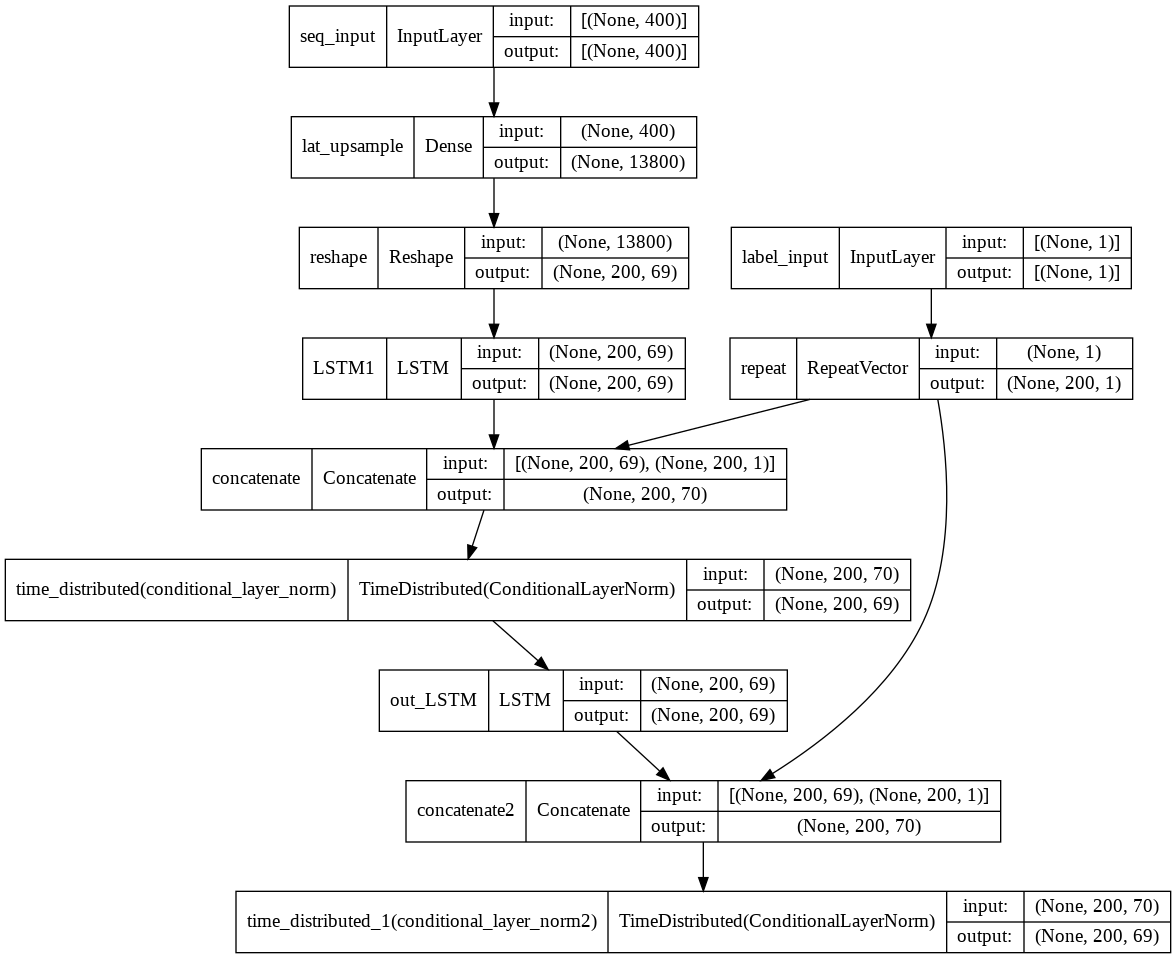

In [11]:
from keras.utils.vis_utils import plot_model
plot_model(generator, show_shapes=True, show_layer_names=True)


In [ ]:
! rm -rf /content/drive/MyDrive/CS490/models/WGAN2022.01.27-14:10:21

In [ ]:
! pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.0 MB/s 


In [ ]:
generator = define_generator(config)

In [85]:
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 seq_input (InputLayer)         [(None, 400)]        0           []                               
                                                                                                  
 lat_upsample (Dense)           (None, 13800)        5533800     ['seq_input[0][0]']              
                                                                                                  
 reshape_25 (Reshape)           (None, 200, 69)      0           ['lat_upsample[0][0]']           
                                                                                                  
 label_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                          

In [ ]:
import json
with open(os.path.join('/content/drive/MyDrive/CS490/models/WGAN_norm_gen2022.02.09-21:32:41/epoch_1', 'cm.txt')) as file:
  cm = json.load(file)

In [ ]:
cm

[[0.0, 0.0, 2.0, 0.0, 0.0, 0.0],
 [7.0, 10.0, 1.0, 2.0, 4.0, 8.0],
 [0.0, 0.0, 1.0, 2.0, 1.0, 0.0],
 [1.0, 0.0, 1.0, 5.0, 1.0, 2.0],
 [1.0, 0.0, 4.0, 0.0, 4.0, 0.0],
 [1.0, 0.0, 1.0, 1.0, 0.0, 0.0]]

<function matplotlib.pyplot.figure>

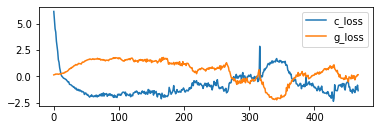

In [31]:
Base_WGAN.plot_history(tm)

In [30]:
import json
with open(os.path.join('/content/drive/MyDrive/CS490/models/WGAN_layer_norm2022.02.12-20:27:59/epoch_9', 'train_metrics.txt')) as file:
  tm = json.load(file)